# 02_DiD_estimates.ipynb

In [55]:
import statsmodels.formula.api as smf
from differences import ATTgt
from differences.did.pscore_cal import pscore_mle
from matplotlib import pyplot as plt
from scipy import stats

import figure_and_table_constants
import figure_utilities
from analysis_utilities import produce_summary_statistics, aggregate_by_time_and_plot, aggregate_by_event_time_and_plot

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
import os
import pandas as pd

# Store paths.
INPUT_DATA = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/restricted.csv"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD/figures"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD/tables"

# Read restricted sample panel dataset into memory.
df = pd.read_csv(INPUT_DATA)

In [56]:
# Create dictionaries to map between string represetation and integer representation of each month.
years = [str(year) for year in range(2013, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = ["2012-12"] + [str(year) + "-" + str(month) for year in years for month in months]
month_to_int_dictionary = {key: value + 1 for value, key in enumerate(value_vars)}
int_to_month_dictionary = {key + 1: value for key, value in enumerate(value_vars)}

In [63]:
# TODO: Build balance table of pretreatment characteristics.
# Run produce summary statistics on the DataFrame to add pre-treatment covariate columns.
produce_summary_statistics(df, 'file_date')

# Build treatment and control mean columns.
pd.options.mode.chained_assignment = None
treatment_means = produce_summary_statistics(df.copy().loc[df['judgment_for_plaintiff'] == 1, :],  # Return treatment means.
                                             'file_date').loc[["Panel A: Case Initiation",
                                                               "Panel C: Defendant and Plaintiff Characteristics",
                                                               "Panel E: Census Tract Characteristics"], 'mean']
treatment_means = treatment_means.rename("Cases Won by Plaintiff")
pre_treatment_covariates = treatment_means.index.get_level_values(1).tolist()  # Save pre-treatment covariates for use in D.R. DiD estimator.
df = df.dropna(subset=pre_treatment_covariates)
pd.options.mode.chained_assignment = 'warn'

# Calculate propensity scores for every observation.
for variable in ['popdensity2010', 'med_hhinc2016']:  # First, replace specified covariates with logged versions of themselves.
    pre_treatment_covariates.remove(variable)
    df.loc[:, 'ln_'+variable] = np.log(df[variable])
    pre_treatment_covariates.append('ln_'+variable)
df.loc[:, 'propensity_score'] = pd.Series(pscore_mle(df['judgment_for_plaintiff'],  # Calculate propensity scores.
                                                     exog=df[pre_treatment_covariates],
                                                     weights=None)[0])

# Build unweighted columns.
difference_unadjusted = []
p_values_unadjusted = []
for covariate in pre_treatment_covariates:
    result = smf.ols(formula=f"{covariate} ~ judgment_for_plaintiff",
                     data=df,
                     missing='drop').fit()
    difference_unadjusted.append(result.params.loc['judgment_for_plaintiff'])
    p_values_unadjusted.append(result.pvalues.loc['judgment_for_plaintiff'])
difference_unadjusted = pd.Series(difference_unadjusted, index=treatment_means.index)
p_values_unadjusted = pd.Series(p_values_unadjusted, index=treatment_means.index)
unweighted_columns = pd.concat([difference_unadjusted, p_values_unadjusted], axis=1)
unweighted_columns.columns = ['Unweighted', '\\emph{p}']

# Build propensity score-weighted columns.
differences_propensity_score_adjusted = []
p_values_propensity_score_adjusted = []
for covariate in pre_treatment_covariates:
    propensity_score_adjusted_result = smf.ols(formula=f"{covariate} ~ judgment_for_plaintiff + propensity_score",
                                               data=df,
                                               missing='drop').fit()
    differences_propensity_score_adjusted.append(propensity_score_adjusted_result.params.loc['judgment_for_plaintiff'])
    p_values_propensity_score_adjusted.append(propensity_score_adjusted_result.pvalues.loc['judgment_for_plaintiff'])
differences_propensity_score_adjusted = pd.Series(differences_propensity_score_adjusted, index=treatment_means.index)
p_values_propensity_score_adjusted = pd.Series(p_values_propensity_score_adjusted, index=treatment_means.index)
propensity_score_weighted_columns = pd.concat([differences_propensity_score_adjusted, p_values_propensity_score_adjusted], axis=1)
propensity_score_weighted_columns.columns = ['Weighted', '\\emph{p}']

difference_columns = pd.concat([unweighted_columns, propensity_score_weighted_columns], axis=1)
table_columns = [treatment_means, difference_columns]
balance_table = pd.concat(table_columns, axis=1, keys=['', 'Difference in Cases Won by Defendant'])

# Rename rows.
variable_display_names_dict = {'for_cause': "For cause", 'no_cause': "No cause", 'non_payment': "Non-payment of rent",
                               # Panel A
                               'case_duration': "Case duration", 'defaulted': "Case defaulted", 'heard': "Case heard",
                               # Panel B
                               'judgment': "Money judgment", 'mediated': "Case mediated", 'dismissed': 'Case dismised',
                               # Panel B
                               'hasAttyD': "Defendant has an attorney", 'hasAttyP': "Plaintiff has an attorney",
                               # Panel C
                               'isEntityD': "Defendant is an entity", 'isEntityP': "Plaintiff is an entity",  # Panel C
                               'TOTAL_VAL': "Total property value", 'BLDG_VAL': "Building value",
                               'LAND_VAL': "Land value",  # Panel D
                               'OTHER_VAL': "Other value",  # Panel D
                               'med_hhinc2016': 'Median household income (2016)',
                               'popdensity2010': 'Population density (2010)',  # Panel E
                               'share_white2010': 'Portion white (2010)',  # Panel E
                               'zestimate_-5_years_relative_to_treatment': "Five years before filing date",  # Panel F
                               'zestimate_-4_years_relative_to_treatment': "Four years before filing date",  # Panel F
                               'zestimate_-3_years_relative_to_treatment': "Three years before filing date",  # Panel F
                               'zestimate_-2_years_relative_to_treatment': "Two years before filing date",  # Panel F
                               'zestimate_-1_years_relative_to_treatment': "One year before filing date",  # Panel F
                               'zestimate_0_years_relative_to_treatment': "Filing date",  # Panel F
                               'zestimate_1_years_relative_to_treatment': "One year after filing date",  # Panel F
                               'zestimate_2_years_relative_to_treatment': "Two years after filing date",  # Panel F
                               'zestimate_3_years_relative_to_treatment': "Three years after filing date"}  # Panel F
balance_table = balance_table.rename(index=variable_display_names_dict)

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "balance_table.tex")
latex = (balance_table
         .style
         .format(thousands=",",
                 formatter={('', 'Cases Won by Plaintiff'): "{:,.2f}",
                            ('Difference in Cases Won by Defendant', 'Unweighted'): "{:,.2f}",
                            ('Difference in Cases Won by Defendant', '\\emph{p}'): "{:,.2f}",
                            ('Difference in Cases Won by Defendant', 'Weighted'): "{:,.2f}",
                            ('', 'N'): "{:,.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .format_index("\\textit{{{}}}", escape="latex", axis=1, level=0)
         .to_latex(None,
                   column_format="llccccc",
                   hrules=True,
                   multicol_align='c',
                   clines="skip-last;data")).replace("{*}", "{3cm}")
with open(filename, 'w') as file:
    file.write(latex)
balance_table

\
                                                                                Cases Won by Plaintiff   
Panel A: Case Initiation                         For cause                                    0.124231   
                                                 No cause                                     0.111111   
                                                 Non-payment of rent                          0.720787   
Panel C: Defendant and Plaintiff Characteristics Defendant has an attorney                    0.066011   
                                                 Plaintiff has an attorney                    0.795818   
                                                 Defendant is an entity                       0.011890   
                                                 Plaintiff is an entity                       0.659697   
Panel E: Census Tract Characteristics            Median household income (2016)           52087.323083   
                                                 Population density (2010)                 9031.635095   
                                                 Portion white (2010)                         0.602099   

                                                                                Difference in Cases Won by Defendant  \
                                                                                                          Unweighted   
Panel A: Case Initiation                         For cause                                                  0.005350   
                                                 No cause                                                  -0.027584   
                                                 Non-payment of rent                                       -0.005320   
Panel C: Defendant and Plaintiff Characteristics Defendant has an attorney                                 -0.135621   
                                                 Plaintiff has an attorney                                  0.011436   
                                                 Defendant is an entity                                     0.003732   
                                                 Plaintiff is an entity                                     0.029160   
Panel E: Census Tract Characteristics            Median household income (2016)                             0.035089   
                                                 Population density (2010)                                  0.057297   
                                                 Portion white (2010)                                       0.056465   

                                                                                               \
                                                                                     \emph{p}   
Panel A: Case Initiation                         For cause                       6.814573e-01   
                                                 No cause                        3.141703e-02   
                                                 Non-payment of rent             7.648551e-01   
Panel C: Defendant and Plaintiff Characteristics Defendant has an attorney       2.890964e-30   
                                                 Plaintiff has an attorney       4.772973e-01   
                                                 Defendant is an entity          3.658050e-01   
                                                 Plaintiff is an entity          1.230461e-01   
Panel E: Census Tract Characteristics            Median household income (2016)  2.113541e-03   
                                                 Population density (2010)       2.459748e-01   
                                                 Portion white (2010)            7.126127e-03   

                                                                                           \
                                                                                 Weighted   
Panel A: Case Initiation               

In [54]:
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_year_variable = treatment_date_variable.replace("date", "year")
treatment_month_variable = treatment_date_variable.replace("date", "month")
df = df.dropna(subset=['file_date', 'latest_docket_date'])
print(f"Limiting sample to {len(df)} evictions for which we observe the filing date and the latest docket"
      f"date.")
cases_per_year = df[
    treatment_year_variable].value_counts()  # Store yearly case counts for use in figure titles in next cell.

# Reshape from wide to long.
df = pd.melt(df,
             id_vars=['case_number', treatment_month_variable, treatment_year_variable,
                      'judgment_for_plaintiff'] + pre_treatment_covariates,
             value_vars=value_vars, var_name='month', value_name='zestimate')
df = df.sort_values(by=['case_number', 'month'])

# Convert months from string format to integer format.
df.loc[:, 'month'] = df['month'].replace(month_to_int_dictionary)
df.loc[:, treatment_month_variable] = df[treatment_month_variable].replace(month_to_int_dictionary)
# Set treatment month to 0 for untreated observations.
never_treated_mask = (df['judgment_for_plaintiff'] == 0)
df.loc[never_treated_mask, treatment_month_variable] = np.NaN
df.loc[never_treated_mask, treatment_year_variable] = np.NaN

# Generate numeric version of case_number.
df.loc[:, 'case_number_numeric'] = df['case_number'].astype('category').cat.codes

# Set index.
df = df.set_index(['case_number', 'month'])

Limiting sample to 2963 evictions for which we observe the filing date and the latest docketdate.


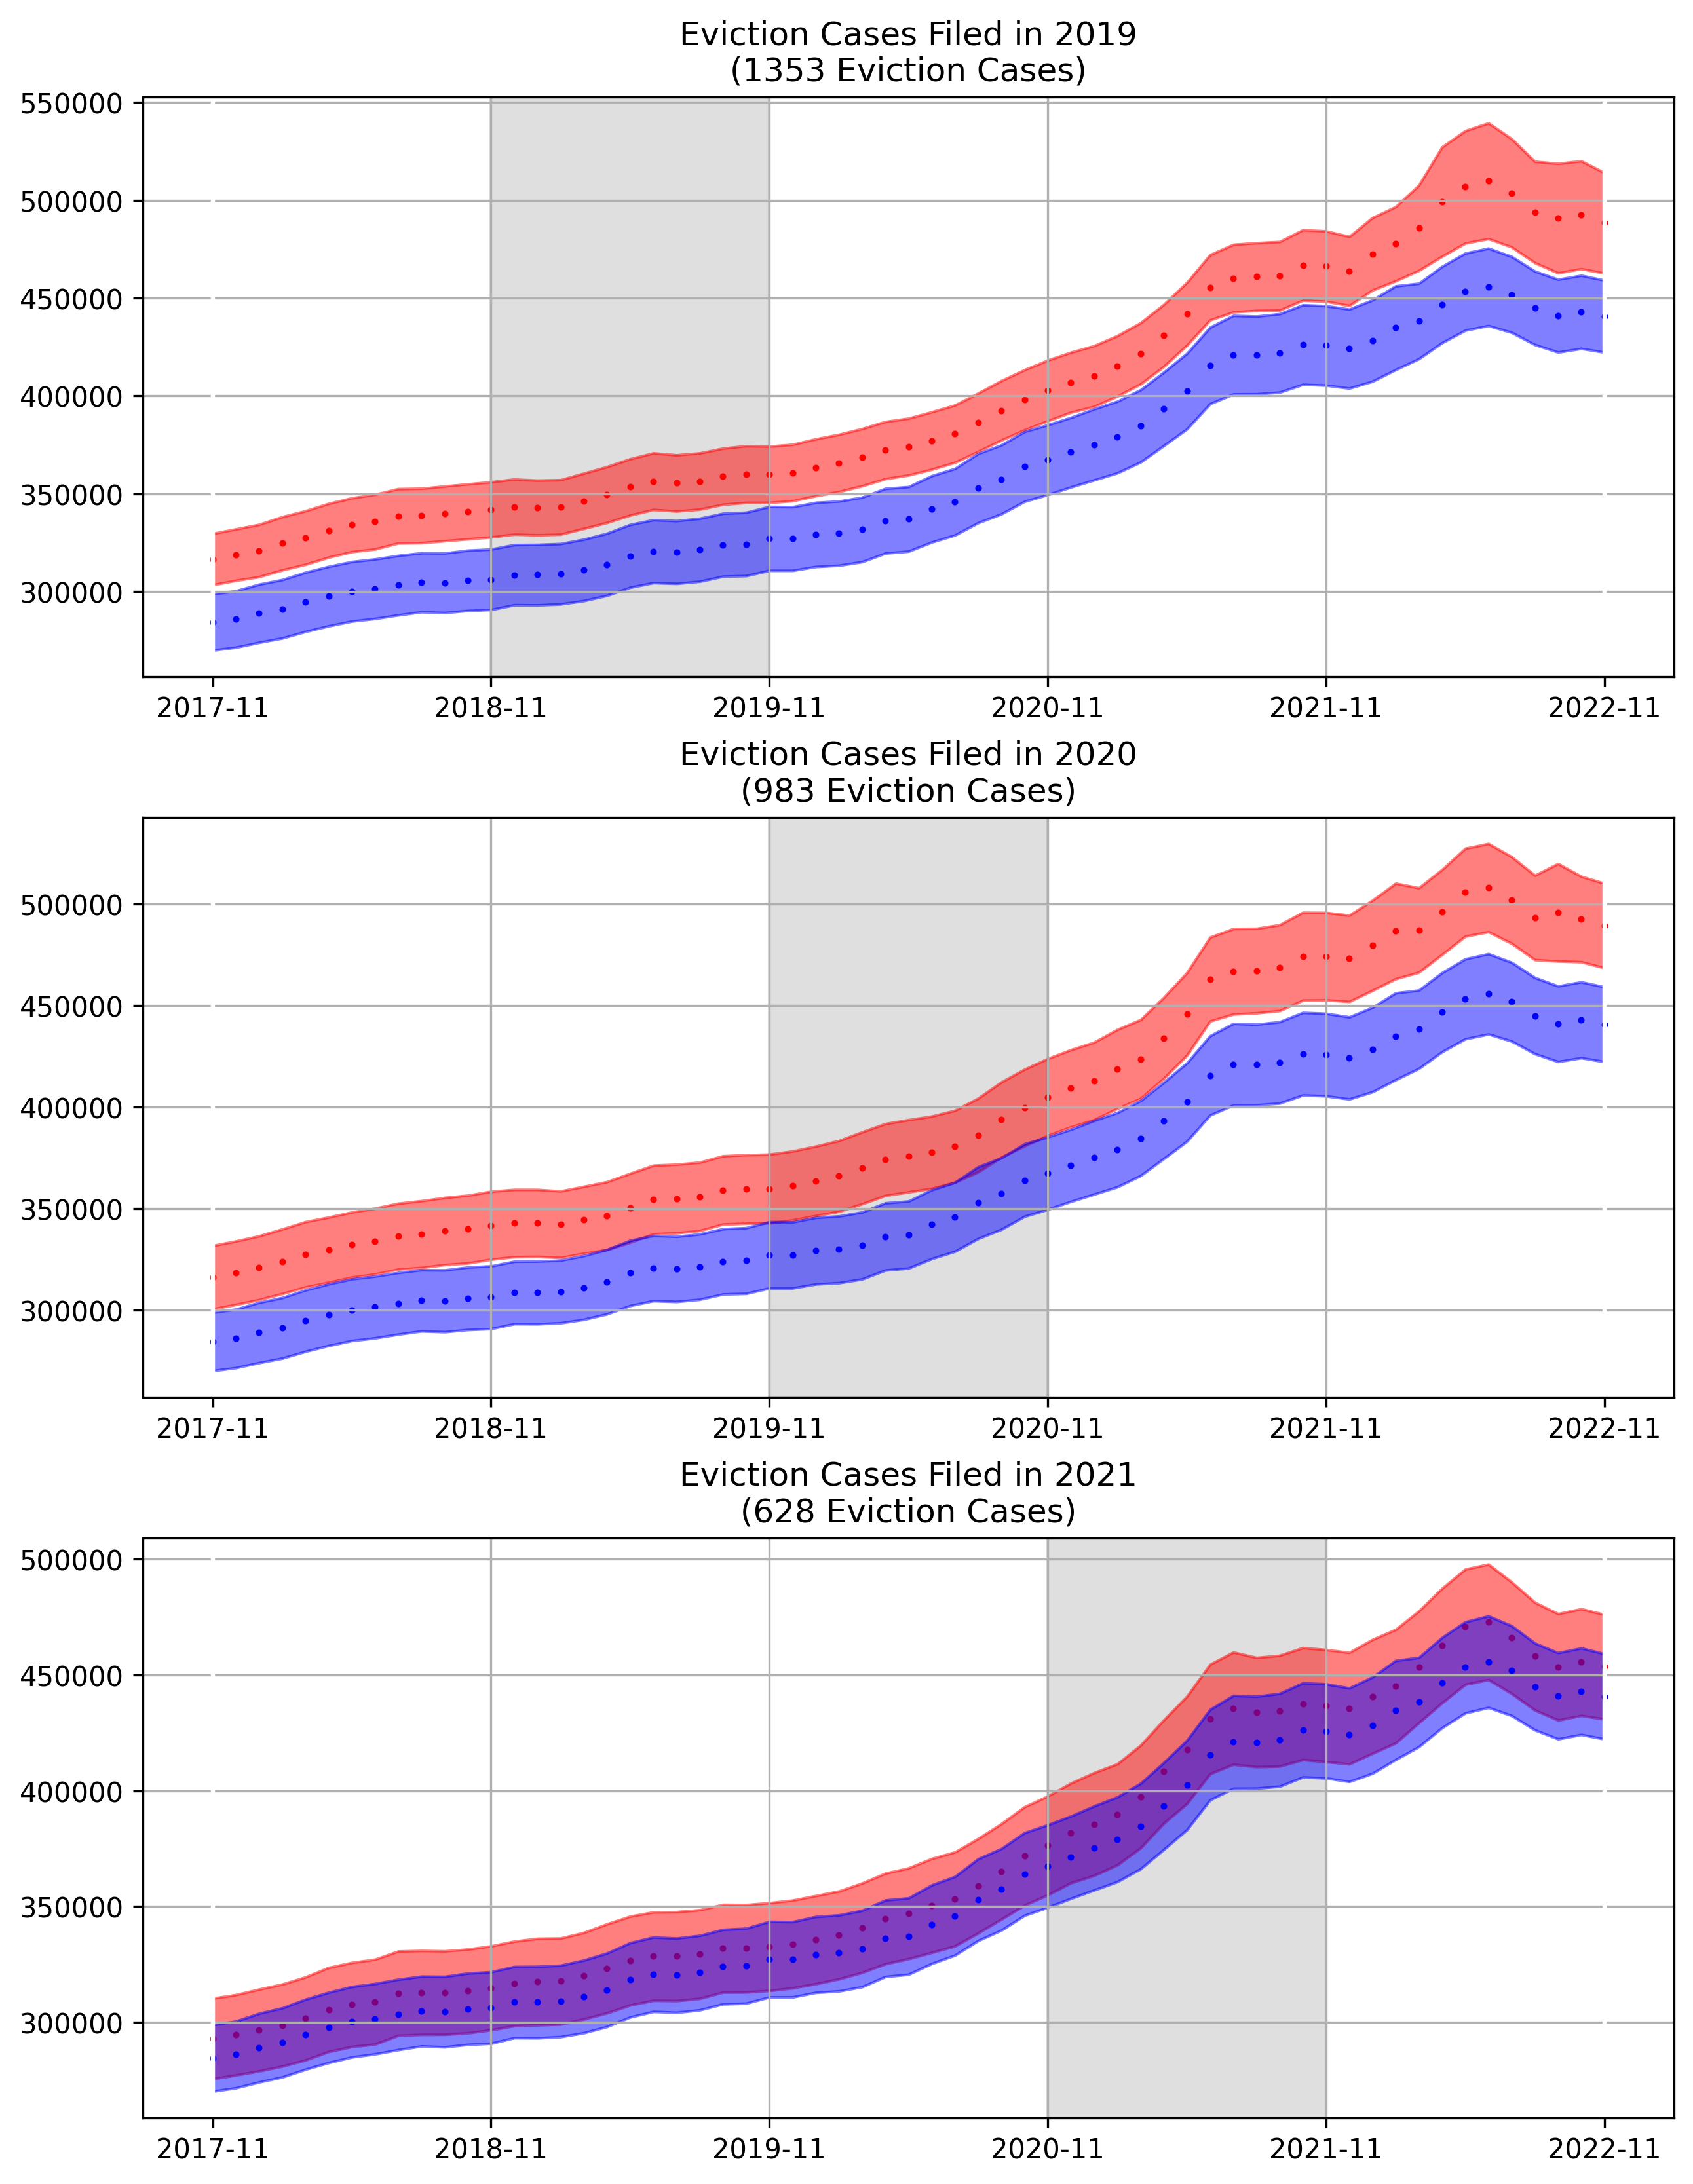

In [5]:
# Plot path of outcomes in treated group vs. control group, separately by year of filing.
# Plot.
aggregated_zestimates = (df
                         .copy().loc[(slice(None), slice(60, 120)),]
                         .groupby([treatment_year_variable, 'month'], dropna=False)['zestimate']
                         .agg([np.mean, np.std, 'count']))
aggregated_zestimates.loc[:, 'se'] = aggregated_zestimates['std'] / np.sqrt(aggregated_zestimates['count'])
aggregated_zestimates.loc[:, 'y_upper'] = aggregated_zestimates['mean'] + 1.96 * aggregated_zestimates['se']
aggregated_zestimates.loc[:, 'y_lower'] = aggregated_zestimates['mean'] - 1.96 * aggregated_zestimates['se']
treatment_times = aggregated_zestimates.index.get_level_values(treatment_year_variable).unique()
fig, axes = plt.subplots(3, 1, layout='constrained', figsize=(8.5, 11))
for ax, aggregated_cohort in zip(axes, treatment_times):
    # No need to plot trends for untreated cohort.
    if np.isnan(aggregated_cohort):
        continue
    # Shade months during which treatment occurred in each aggregated cohort.
    start_shading = 12 * (int(aggregated_cohort) - 2017 - 1)
    end_shading = start_shading + 12
    ax.axvspan(start_shading, end_shading, color=figure_and_table_constants.Colors.LABELING_COLOR,
               alpha=0.25)
    sub_df_treatment = aggregated_zestimates.loc[aggregated_cohort, :]
    count_treatment = sub_df_treatment['count'].sum()
    y_treatment = sub_df_treatment['mean'].values
    x_treatment = pd.Series(sub_df_treatment.index.get_level_values('month')).replace(int_to_month_dictionary).values
    y_upper_treatment = sub_df_treatment['y_upper'].values
    y_lower_treatment = sub_df_treatment['y_lower'].values

    figure_utilities.plot_scatter_with_shaded_errors(ax,
                                                     x_treatment,
                                                     y_treatment,
                                                     y_upper_treatment,
                                                     y_lower_treatment,
                                                     point_color=figure_and_table_constants.Colors.TREATMENT_COLOR,
                                                     error_color=figure_and_table_constants.Colors.TREATMENT_COLOR,
                                                     edge_color=figure_and_table_constants.Colors.TREATMENT_COLOR,
                                                     edge_style='-',
                                                     error_opacity=0.5)

    sub_df_control = (aggregated_zestimates.loc[aggregated_zestimates.index.get_level_values(treatment_year_variable)
                                                .isna(), :])
    count_control = sub_df_control['count'].sum()
    y_control = sub_df_control['mean'].values
    x_control = pd.Series(sub_df_control.index.get_level_values('month')).replace(int_to_month_dictionary).values
    y_upper_control = sub_df_control['y_upper'].values
    y_lower_control = sub_df_control['y_lower'].values
    figure_utilities.plot_scatter_with_shaded_errors(ax,
                                                     x_control,
                                                     y_control,
                                                     y_upper_control,
                                                     y_lower_control,
                                                     point_color=figure_and_table_constants.Colors.CONTROL_COLOR,
                                                     error_color=figure_and_table_constants.Colors.CONTROL_COLOR,
                                                     edge_color=figure_and_table_constants.Colors.CONTROL_COLOR,
                                                     edge_style='-',
                                                     error_opacity=0.5)
    ax.set_xticks(range(0, len(x_treatment), 12))
    ax.grid(True)

    if treatment_date_variable == 'file_date':
        verb = 'Filed'
    elif treatment_date_variable == 'latest_docket_date':
        verb = 'Concluded'
    else:
        raise ValueError("Invalid treatment_date_variable.")
    ax.set_title(f"Eviction Cases {verb} in {int(aggregated_cohort)}\n"
                 f"({cases_per_year.loc[int(aggregated_cohort)]} Eviction Cases)")
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "trends_in_zestimates_by_cohort.png"))

In [12]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
result = att_gt.fit(formula='zestimate', control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 3000/3000 [01:12<00:00, 41.22it/s]


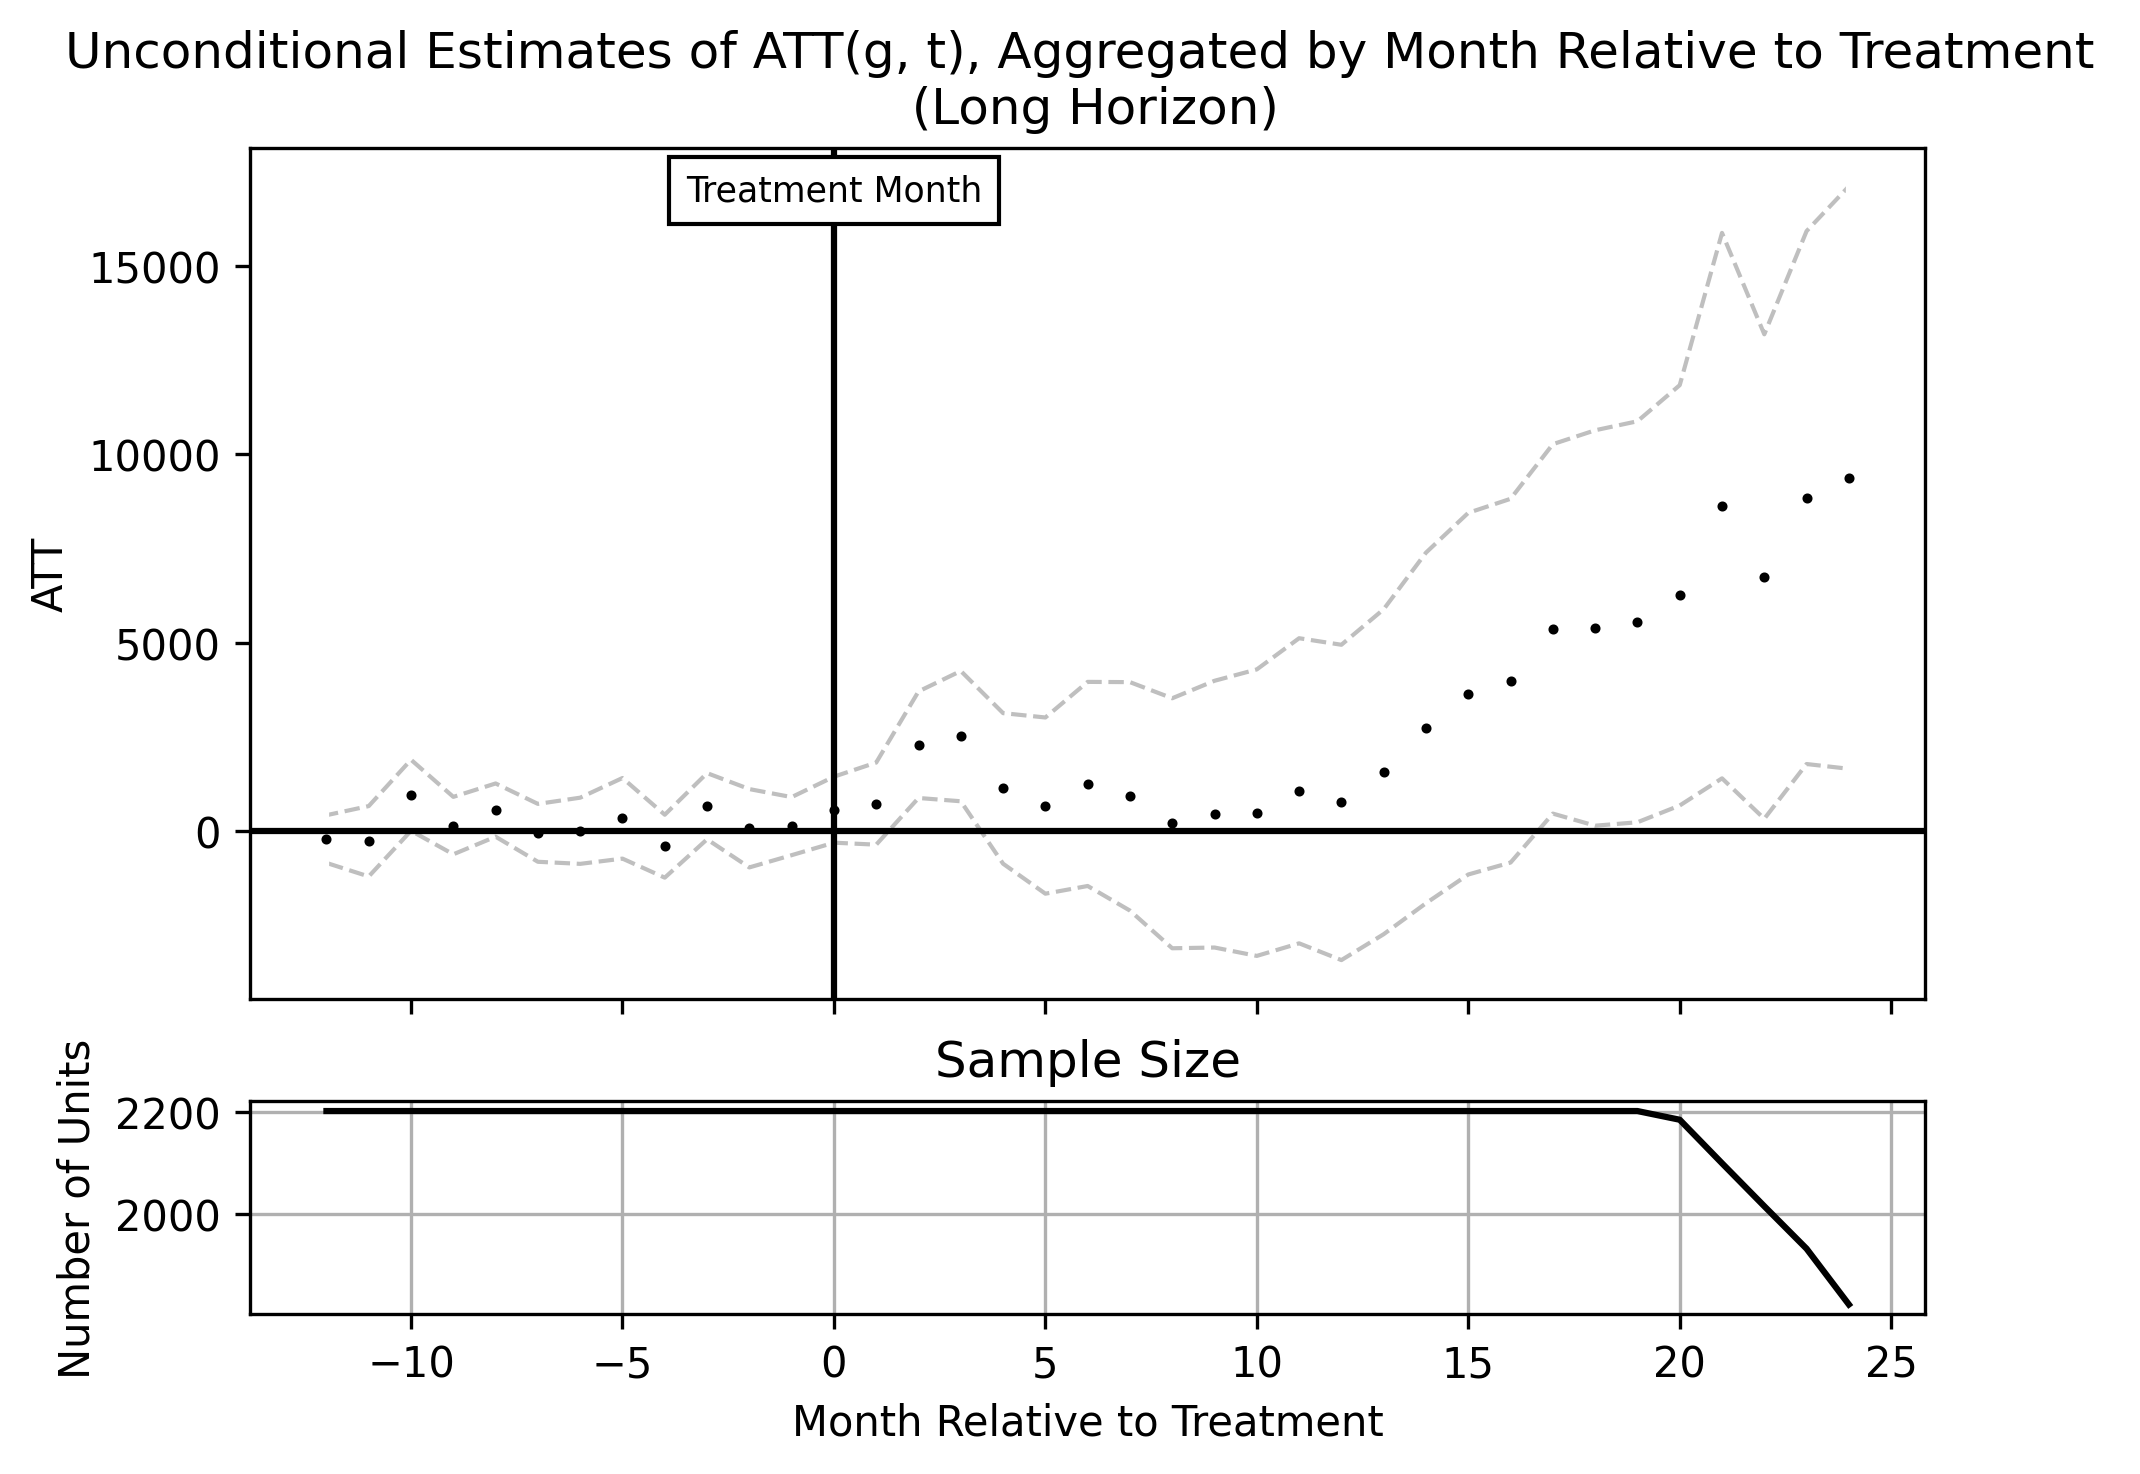

In [14]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-12, end_period=24,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

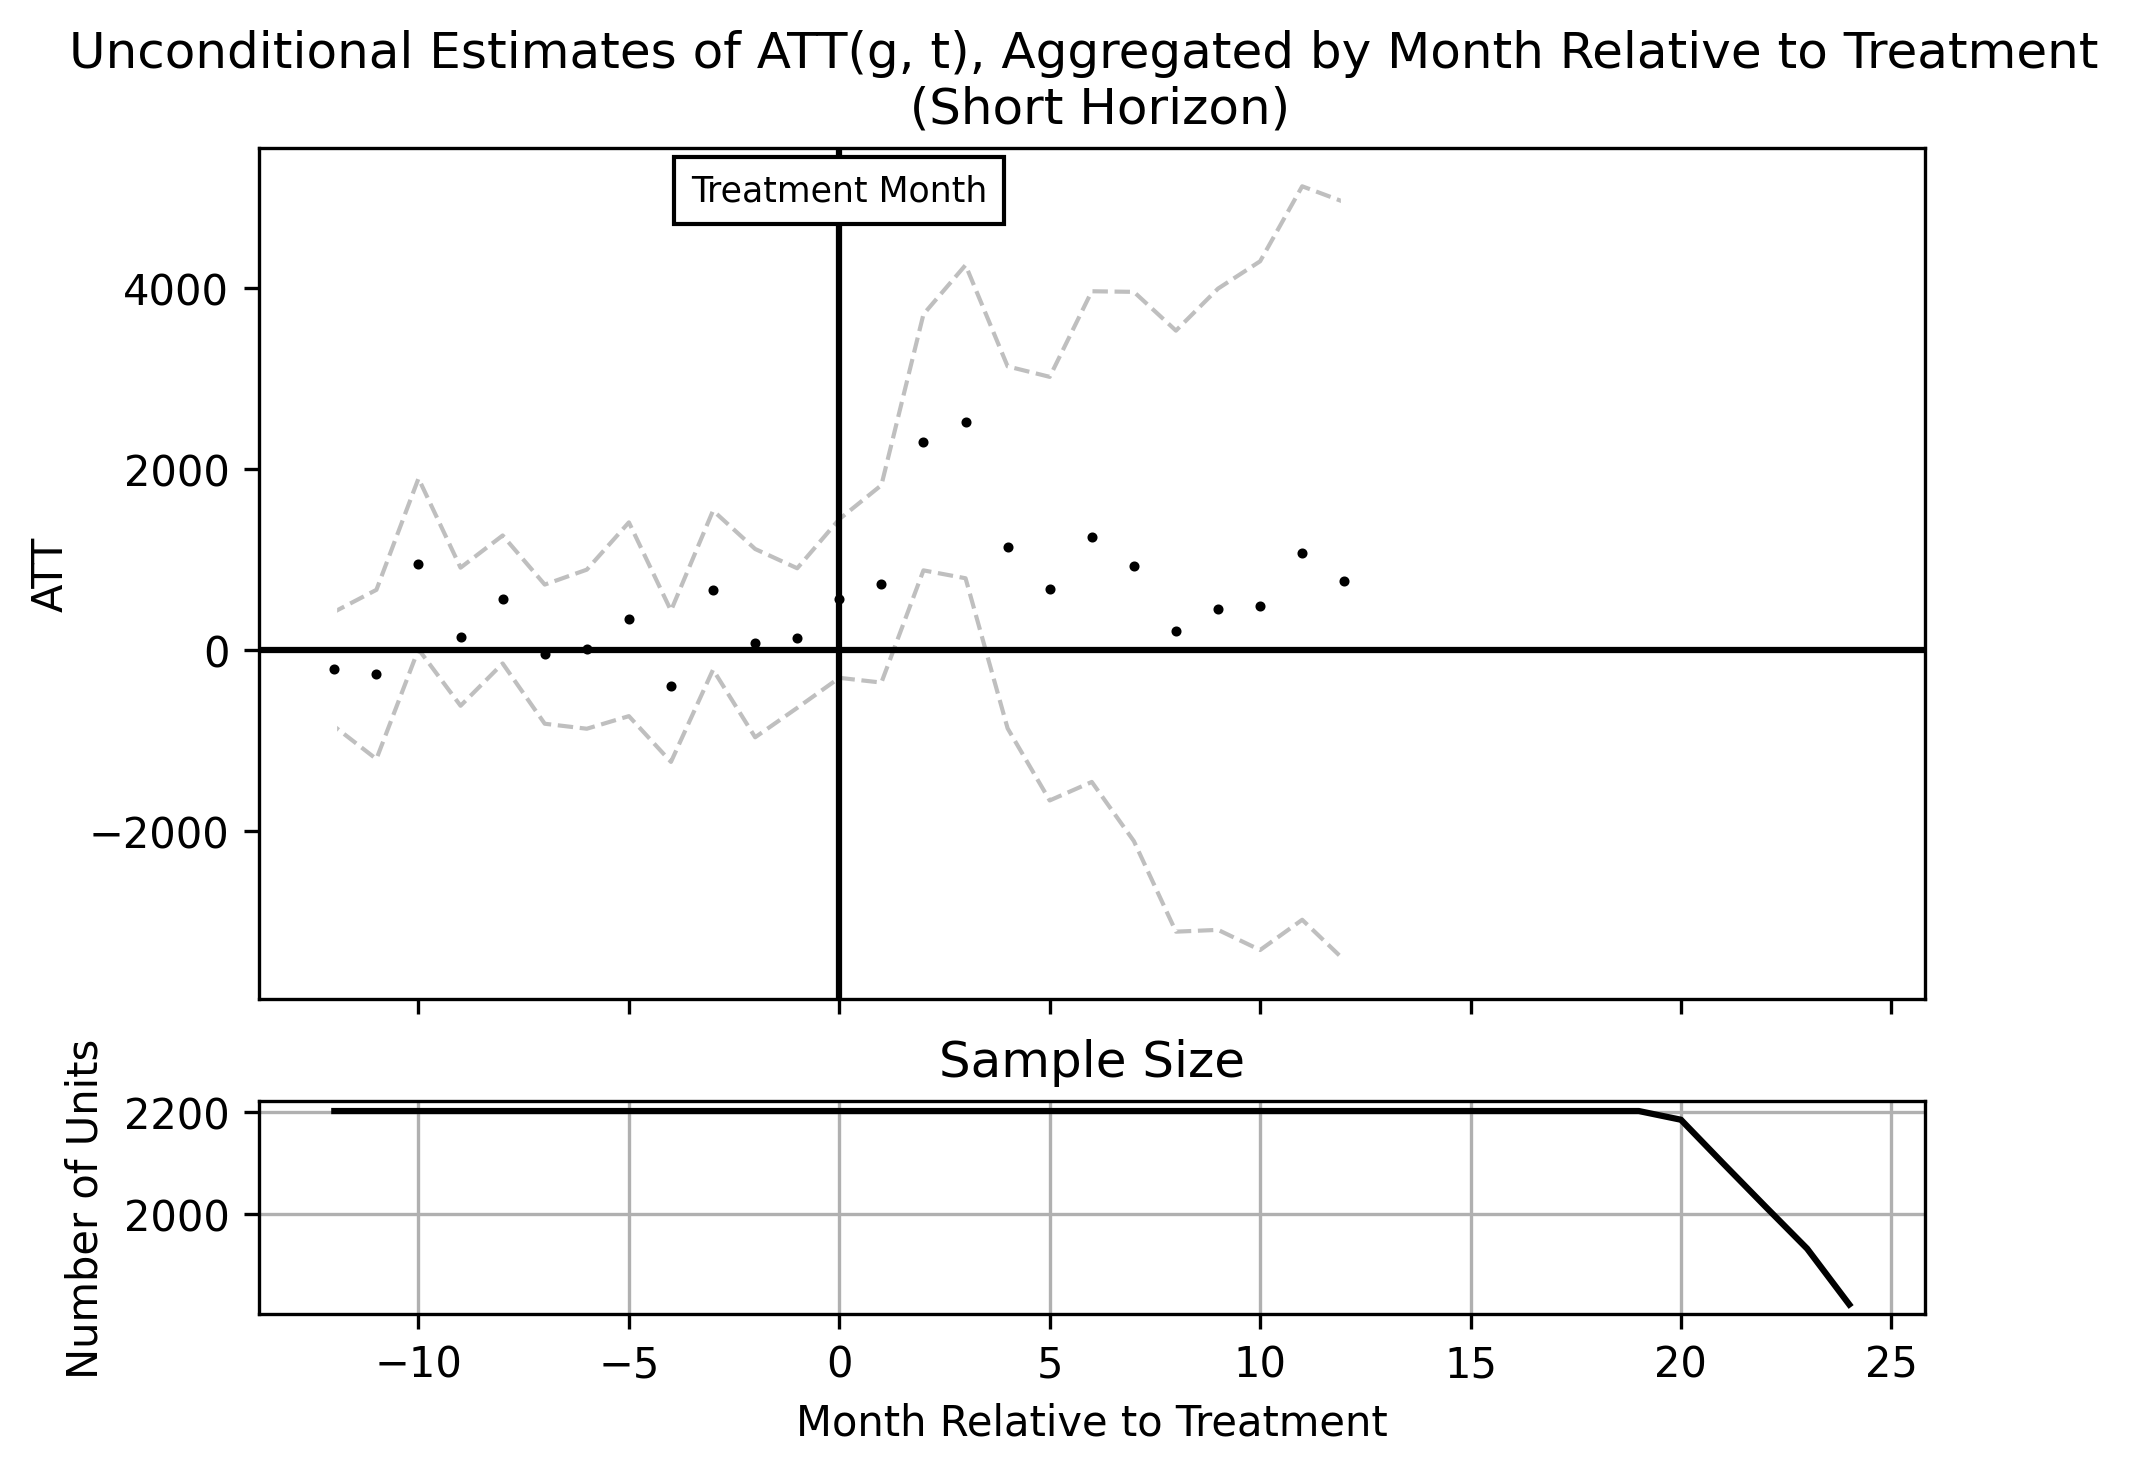

In [15]:
# Plot unconditional ATT(t-g)s on a short horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_short_horizon.png",
                                 start_period=-12, end_period=12,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Short Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

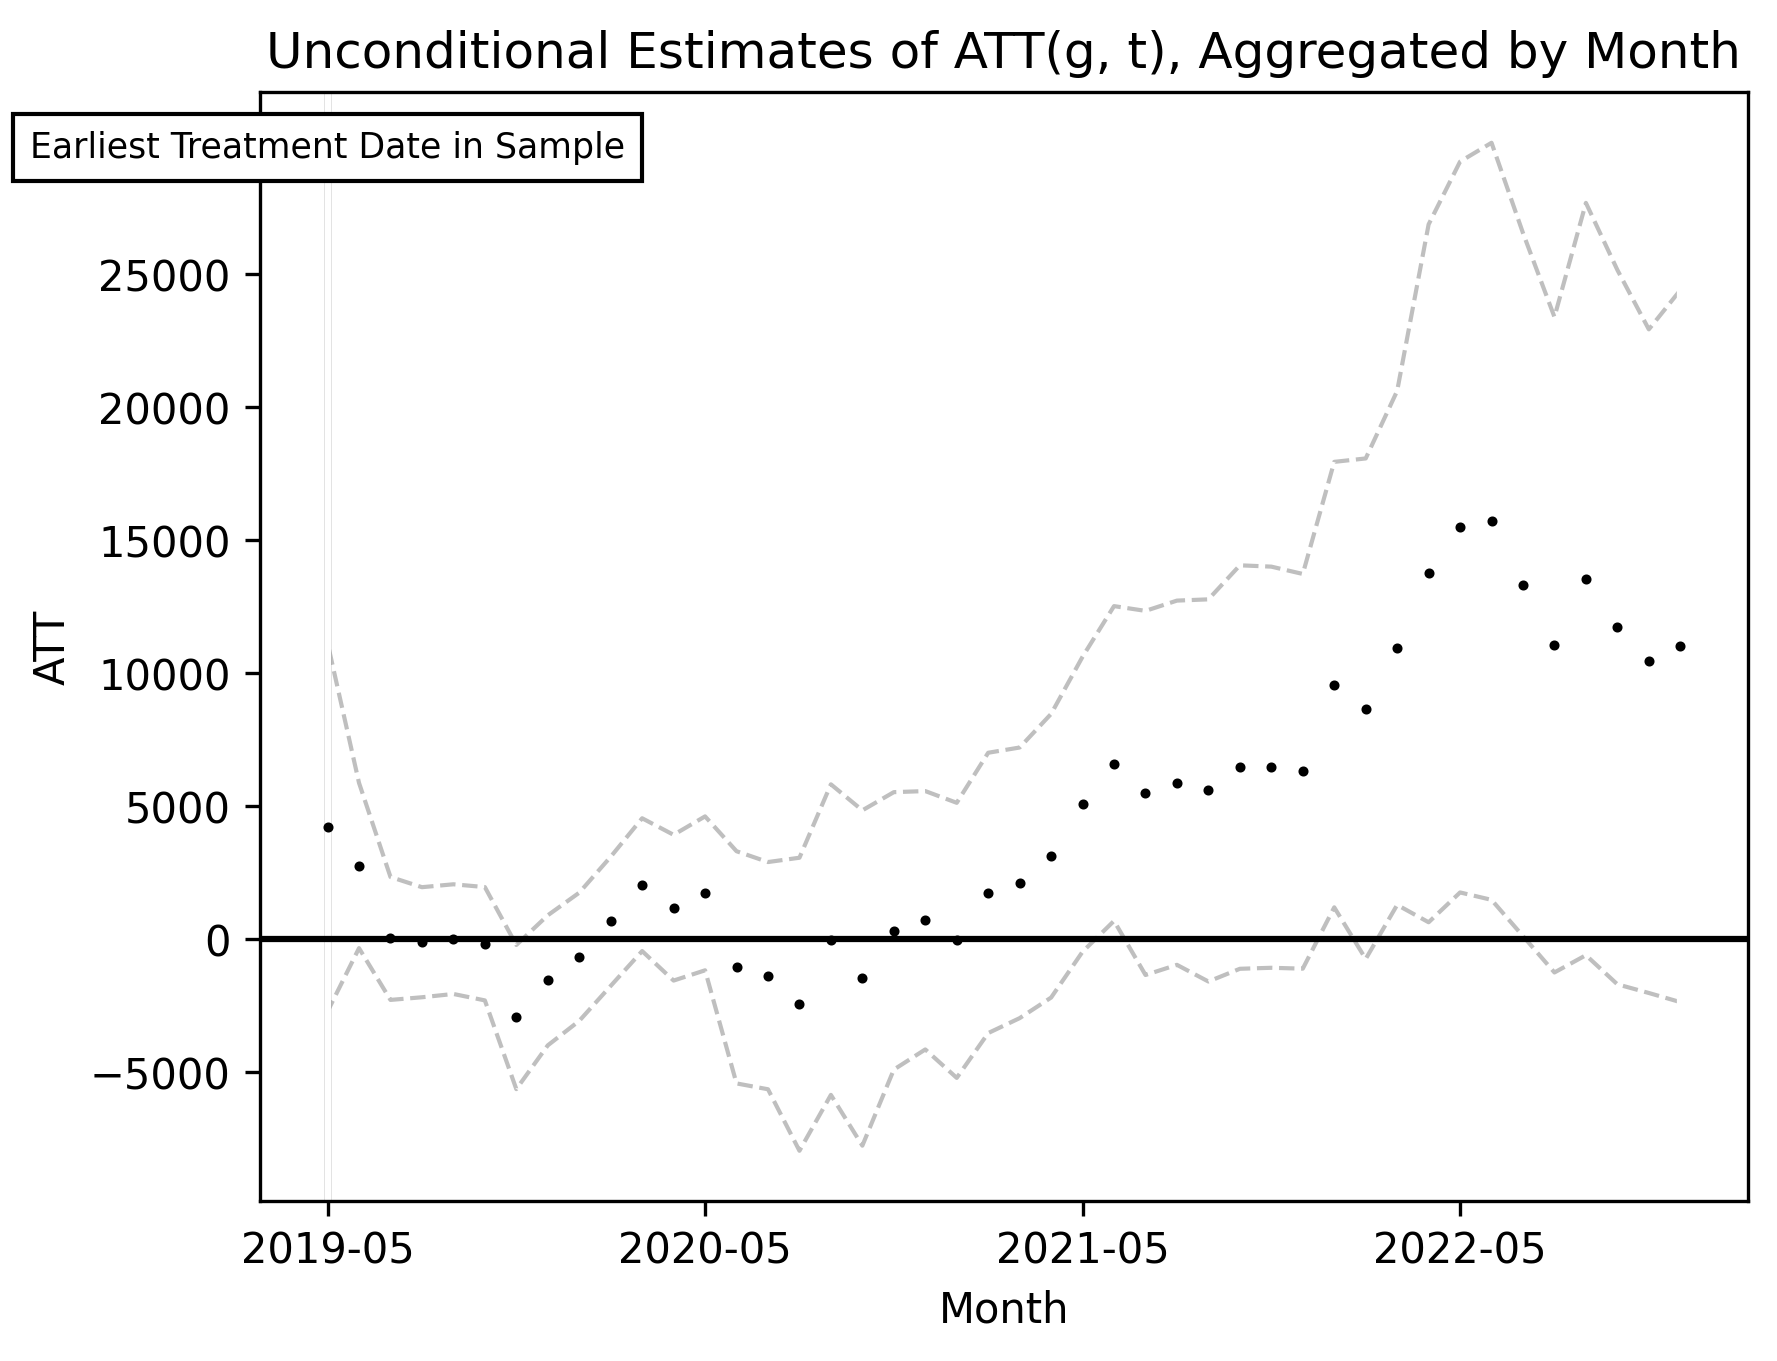

In [9]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="Unconditional Estimates of ATT(g, t), Aggregated by Month")

In [16]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
formula = 'zestimate ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 3000/3000 [02:09<00:00, 23.22it/s]


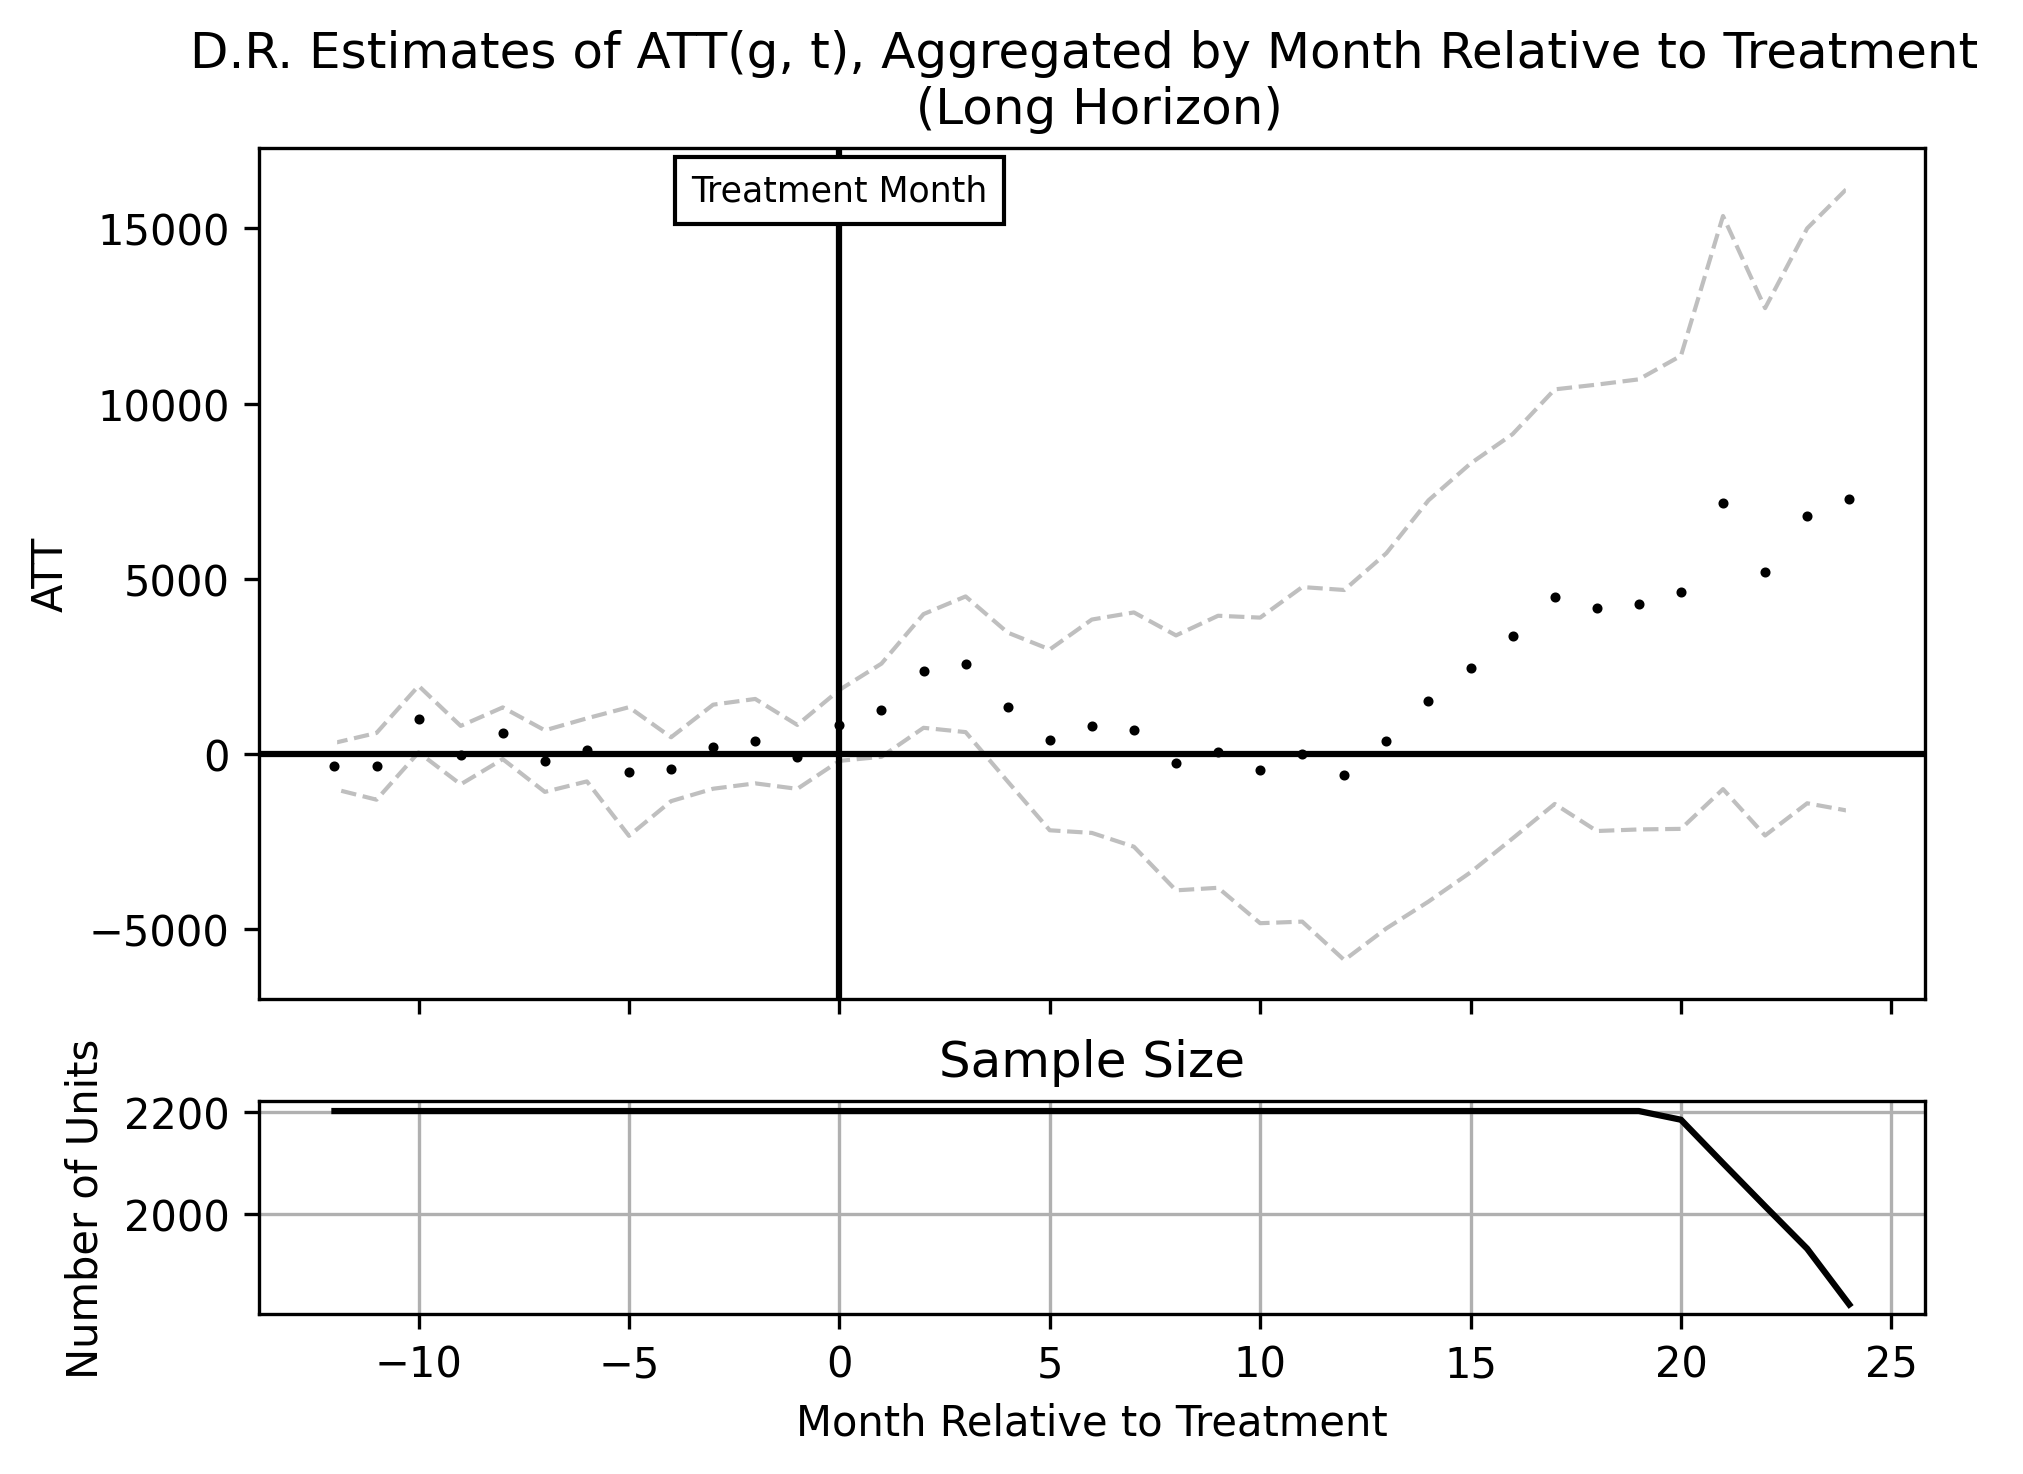

In [17]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-12,
                                 end_period=24,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

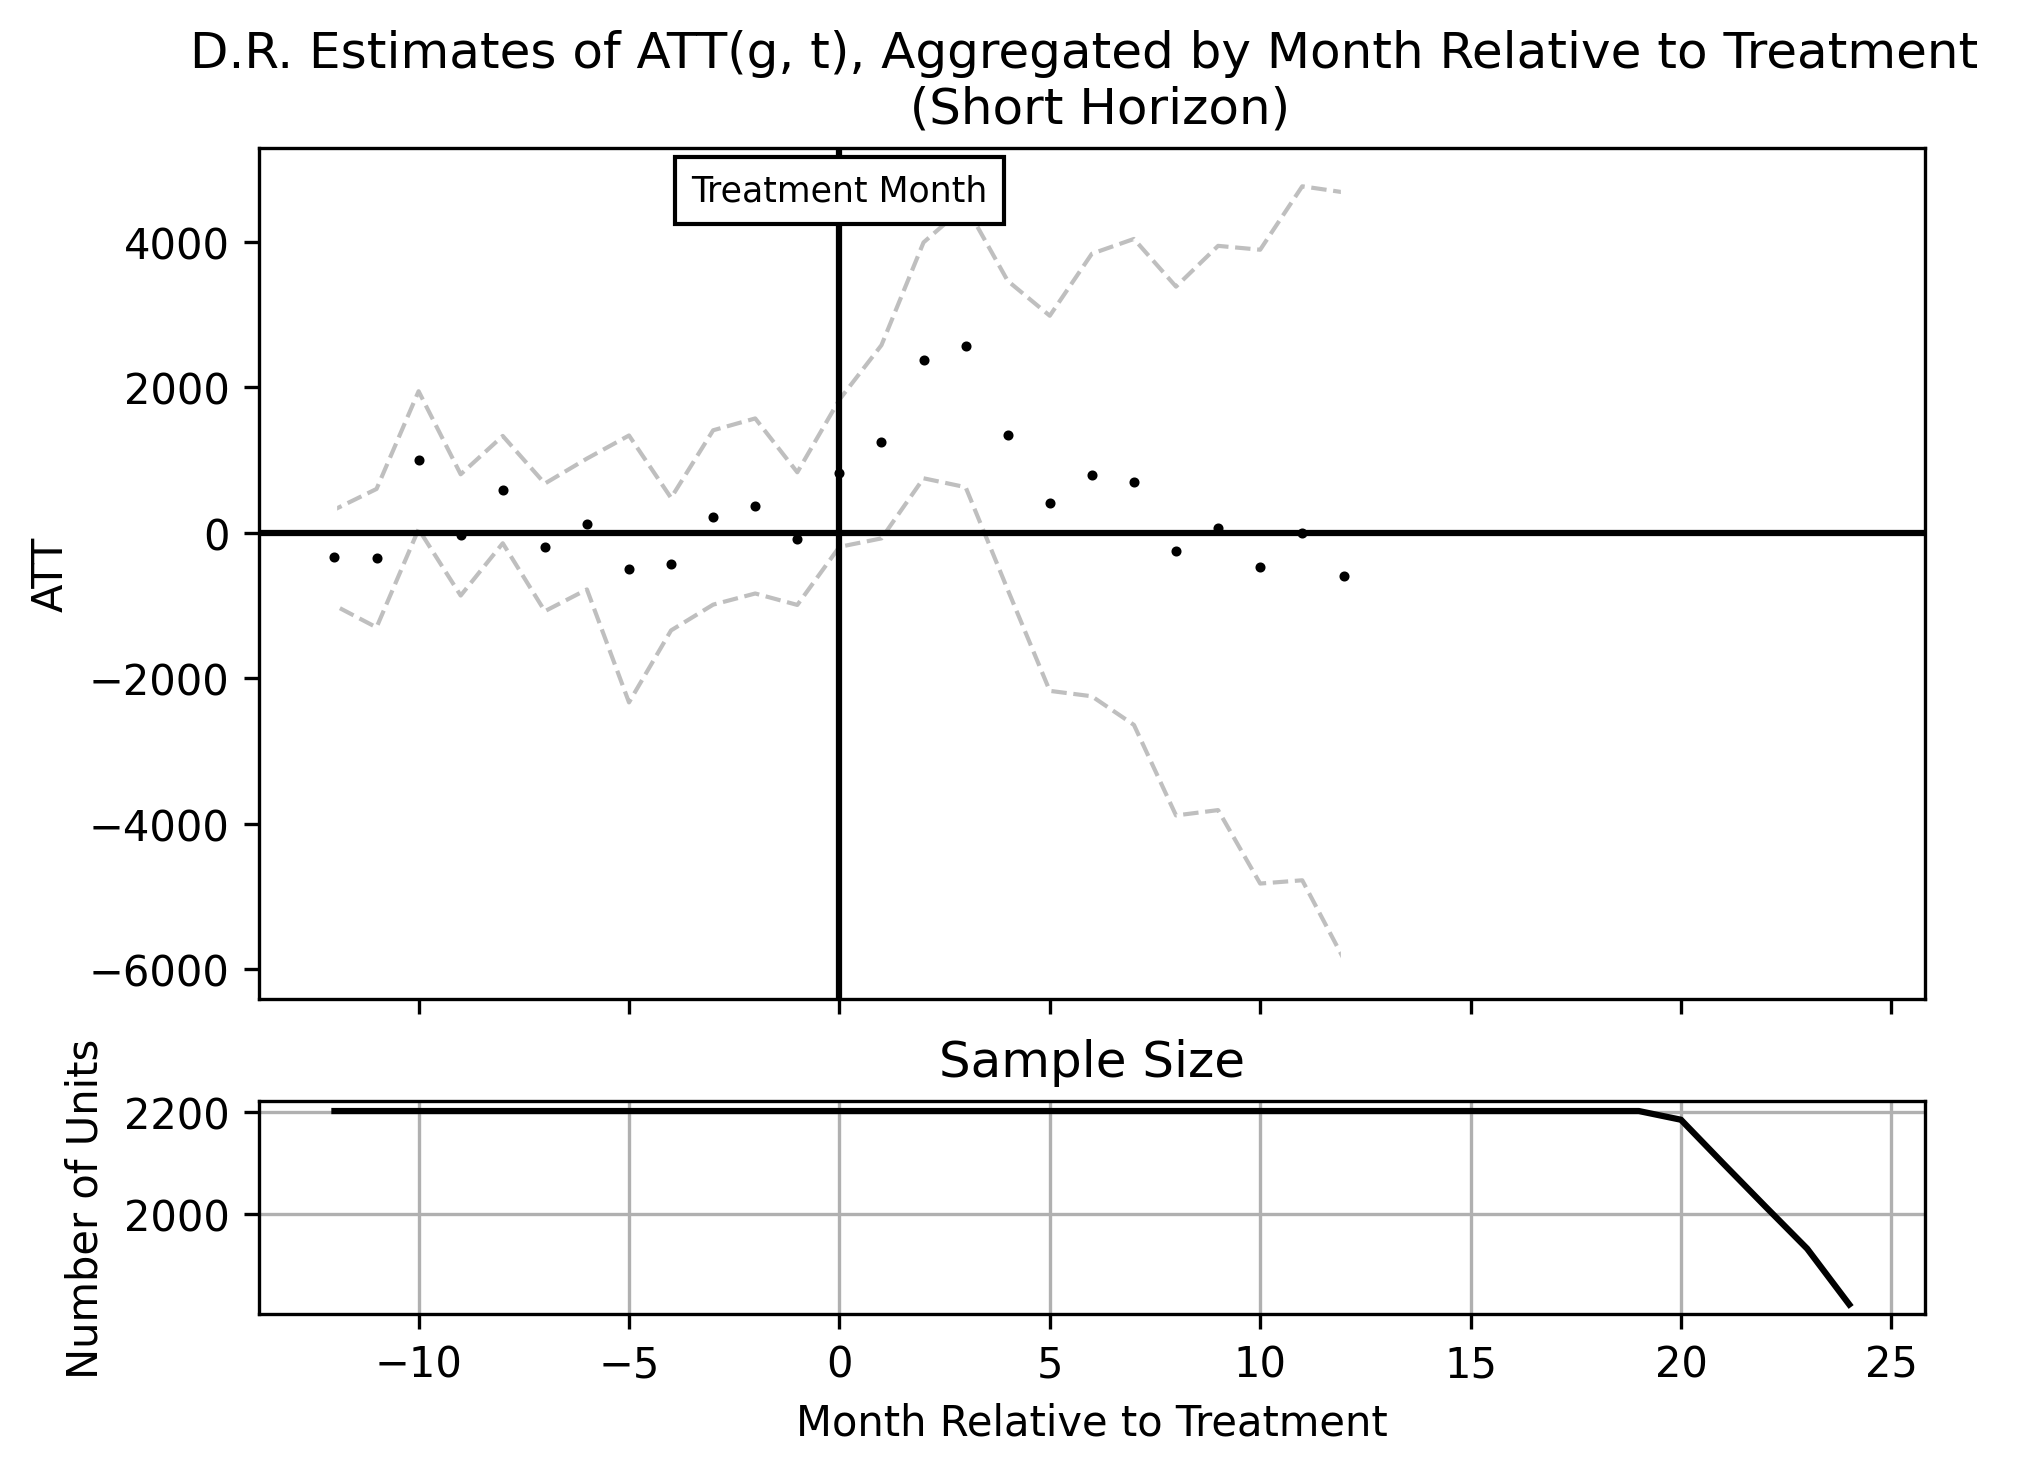

In [18]:
# Plot D.R. ATT(t-g)s on a short horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_short_horizon.png", start_period=-12,
                                 end_period=12,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Short Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

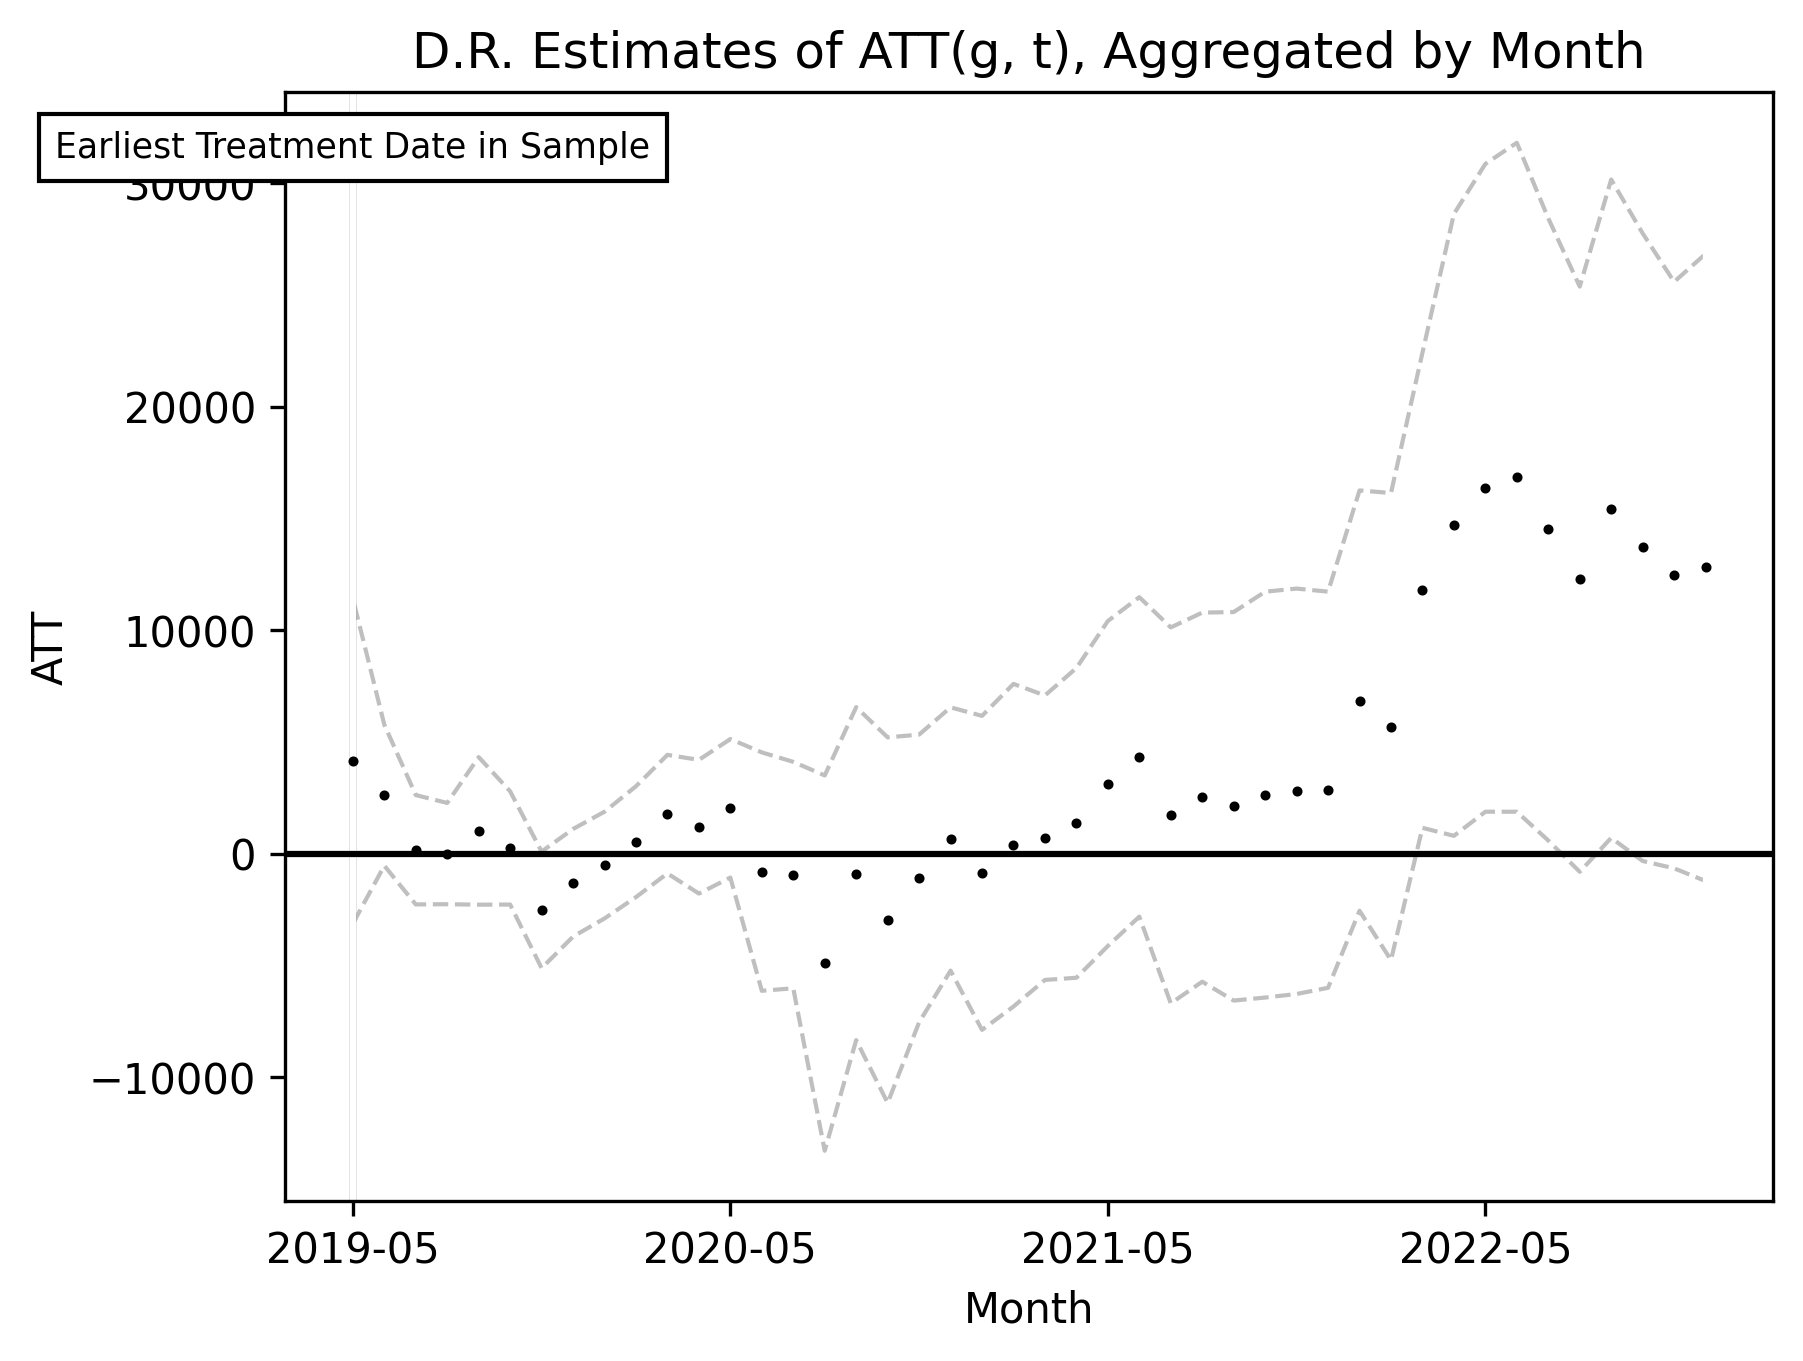

In [19]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="D.R. Estimates of ATT(g, t), Aggregated by Month")